In [117]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150
rcParams["text.usetex"] = True
import tqdm

In [118]:
import numpy as np
import scipy.special as sps
import scipy.integrate as integrate

In [119]:
np.warnings.filterwarnings('ignore')

In [120]:
from maoud import ComplexAlphaMu, AlphaMu
from maoud import mpsk
from maoud import marcumq

In [121]:
K = int(1e6) # Number of Monte Carlo realizations
N = 25      # Number of transmitted samples
L = 15      # Number of pairs to simulate
M = 64.       # Size of the constellation
alpha, mu = 2., 1.

In [122]:
alphamu = ComplexAlphaMu(alpha, mu)

In [123]:
x = np.linspace(1e-3, 3., 1000) # Support of the fading density

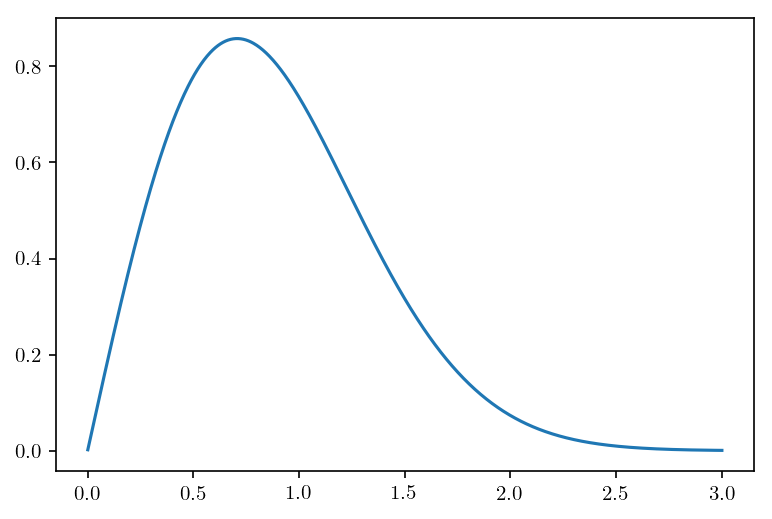

In [124]:
plt.plot(x, alphamu.envelope_pdf(x))

## Simulation

In [125]:
s = mpsk(M, (K, N))

In [126]:
Es = 1.0/M
snr_db = 5
sigma2 = Es * (10 ** (-snr_db / 10.))

h = alphamu.rvs(x=x, y=x, size=K).reshape(-1, 1)
w = np.sqrt(sigma2/2)*np.random.randn(K, N) + 1j*np.sqrt(sigma2/2)*np.random.randn(K, N)

H0 = w 
H1 = h*s + w

# energy statistic
EH0 = H0.real ** 2 + H0.imag ** 2
EH1 = H1.real ** 2 + H1.imag ** 2

EH0 = np.sum(EH0, 1)
EH1 = np.sum(EH1, 1)

# generate the thresholds
delta = np.linspace(np.min(EH0), np.max(EH0), L)

pf = np.zeros(L)
pd = np.zeros(L)

# computing probabilities of false alarm and detection
for l in tqdm.tqdm(range(L)):
    pf[l] = np.sum(EH0 > delta[l])
    pd[l] = np.sum(EH1 > delta[l])

pf = pf / K
pd = pd / K

100%|██████████| 15/15 [00:00<00:00, 201.45it/s]


## Theorectical Analysis

In [127]:
T = 100
delta = np.linspace(np.min(EH0), np.max(EH0), T)

Pd = np.zeros(T)
Pf = 1.0 - sps.gammainc(N, delta / sigma2)
for l in tqdm.tqdm(range(T)):
    cdf = lambda x: marcumq(np.sqrt(2.0*delta[l]/sigma2),N,np.sqrt(2*x*x*N*Es/sigma2))*alphamu.envelope_pdf(x) 
    Pd[l] = integrate.quad(cdf, 0.0, np.inf, epsrel=1e-9, epsabs=0)[0]

100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


## Plot

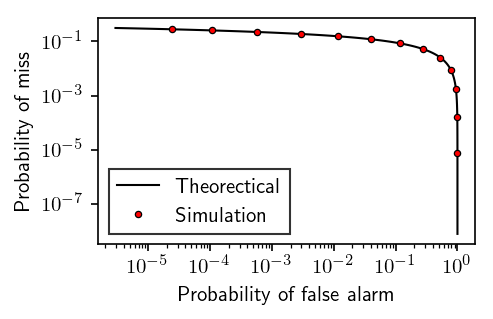

In [128]:
fig, ax = plt.subplots(figsize=(3.2360679775, 2))
ax.loglog(Pf, 1-Pd, 'k-', linewidth=1, label=r"Theorectical")
ax.loglog(pf, 1-pd, 'o', color='red', markeredgecolor='k', mew=.6, markersize=3., label=r"Simulation")
ax.tick_params(axis='x', which='minor', bottom='on')
plt.xlabel(r'Probability of false alarm')
plt.ylabel(r'Probability of miss')
plt.legend(fancybox=False, numpoints=1, edgecolor='k')
plt.savefig('spectrum_sensing.ps', transparent=True, bbox_inches='tight', pad_inches=.1)